In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import sys
import json
from climate_invariant_funcs import create_SHIPS_predictors_dyn, create_SHIPS_predictors_IR, calculate_MPI

#### 1. Load scale factors for SHIPS data.  
We need to rescale some of the SHIPS predictors as many of them have been scaled up to make their values ints instead of floats. 

In [2]:
with open('/home/mmcgraw/ML_for_TC_RI/SHIPS_factors.txt') as f:
    SHIPS_factors = f.read()
SHIPS_js = json.loads(SHIPS_factors)

Load each basin separately

In [3]:
load_path = '/home/mmcgraw/ML_for_TC_RI/DATA/processed/SHIPS_predictors_full_'
BASIN_all = ['ATLANTIC','EAST_PACIFIC','WEST_PACIFIC','CENTRAL_PACIFIC','SOUTHERN_HEM']
SHIPS_load = pd.DataFrame()
for basin_sel in BASIN_all:
    fname_load = load_path+'{reg}.csv'.format(reg=basin_sel)
    iSHIPS_load = pd.read_csv(fname_load)
    iSHIPS_load = iSHIPS_load.drop(columns='Unnamed: 0')
    iSHIPS_load['BASIN'] = basin_sel
    SHIPS_load = SHIPS_load.append(iSHIPS_load)

Now, we rescale the SHIPS predictors.  We take the scaling factors from the `json` file we created earlier and divide a given predictor by its scaling factor (assuming it has one; not all predictors have scaling factors). 

In [4]:
col_names = SHIPS_load.columns
for i_col in col_names:
    print('feature is ',i_col)
    if i_col in SHIPS_js.keys():
        # print("yay")
        factor = SHIPS_js[i_col][0]
        print('divide by ',factor)
        SHIPS_load[i_col] = SHIPS_load[i_col]/factor
   # else:
    #    print("nay")

feature is  CASE
feature is  NAME
feature is  ATCF ID
feature is  DATE_full
feature is  TIME
divide by  1
feature is  VMAX
divide by  1
feature is  MSLP
divide by  1
feature is  TYPE
divide by  1
feature is  HIST
divide by  1
feature is  DELV
divide by  1
feature is  INCV
divide by  1
feature is  LAT
divide by  10
feature is  LON
divide by  10
feature is  CSST
divide by  10
feature is  CD20
divide by  1
feature is  CD26
divide by  1
feature is  COHC
divide by  1
feature is  DTL
divide by  1
feature is  OAGE
divide by  10
feature is  NAGE
divide by  10
feature is  RSST
divide by  10
feature is  RSST_AGE
feature is  DSST
divide by  10
feature is  DSST_AGE
feature is  DSTA
divide by  10
feature is  DSTA_AGE
feature is  U200
divide by  10
feature is  U20C
divide by  10
feature is  V20C
divide by  10
feature is  E000
divide by  10
feature is  EPOS
divide by  10
feature is  ENEG
divide by  10
feature is  EPSS
divide by  10
feature is  ENSS
divide by  10
feature is  RHLO
divide by  1
feature 

#### 2. Create ATCF IDs for SH/WP since I forgot to read them in

Create ATCF IDs for SH and WP. Just add first 2 digits of 'NAME' (which is always SH/WP, respectively), the year, and the last 2 digits of 'NAME' (cyclone no for that year). 

In [5]:
SHIPS_load['id test'] = SHIPS_load['NAME'].str[:2]+pd.to_datetime(SHIPS_load['DATE_full']).dt.year.astype(str)+SHIPS_load['NAME'].str[2:4]
#df.loc[df.ID == 103, 'FirstName'] = "Matt"
SHIPS_load.loc[SHIPS_load.BASIN == 'SOUTHERN_HEM', 'ATCF ID'] = SHIPS_load.loc[SHIPS_load.BASIN == 'SOUTHERN_HEM', 'id test']
SHIPS_load.loc[SHIPS_load.BASIN == 'WEST_PACIFIC', 'ATCF ID'] = SHIPS_load.loc[SHIPS_load.BASIN == 'WEST_PACIFIC', 'id test']


#### 3. Remove flags, non-TCs, landfalling TCs
Clean the data by removing the following:
* <b>Missing data</b>: mask out predictors with missing values (`flag = 9999.0`)
* <b>Non-TC cases</b>: following SHIPS protocol, if `TYPE != 1`, that case is not a TC. Mask these cases
* <b>Landfalling TCs</b>: since our model breaks down when TCs make landfall, we apply a filter based on `DTL` (distance to land).  We only keep predictions where DTL >= `dtl_thresh`. We test 50 and 100 km. 
* <b>Earlier years</b>: Finally, SHIPS data quality and sources have changed a lot since the 1990s. For now, we keep only cases from 2005 and beyond. One, our GOES predictors start coming into use around this time. Two, our ocean-based predictors were changed substantially around this time.  


In [6]:
# Keep only the TCs: TYPE == 1
SHIPS_trim = SHIPS_load[SHIPS_load['TYPE'] == 1]
# Mask any missing values
flag = 9999
SHIPS_trim = SHIPS_trim.mask(SHIPS_trim == flag)
# Mask landfalling TCs
dtl_thresh = 50 #[km]
SHIPS_trim = SHIPS_trim[SHIPS_trim['DTL']>=dtl_thresh]
# Keep only years from 2005-present
first_year = 2005
SHIPS_trim['Year'] = pd.to_datetime(SHIPS_trim['DATE_full']).dt.year
SHIPS_trim = SHIPS_trim[SHIPS_trim['Year']>=first_year]
SHIPS_trim['Year'] = SHIPS_trim['Year'].astype(int)

#### 4a. Calculate $k$-based and CAPE based MPI

<i>Note:</i> This is following the introductory material of Rousseau-Rizzi et al. (2022) (doi:https://doi.org/10.1175/JCLI-D-21-0360.1): 
$$ PI^2_k \approx \frac{c_k}{c_d} \frac{\left(T_s - T_o\right)}{T_o} \left(k^∗_s − k_a\right), $$

$$ MPI^2_{CAPE} = MPI^2_k + \left(\frac{c_k}{c_d}\right) \frac{T_s}{T_o} \left[c_l\times T_o\times \ln{\left(\frac{T_o}{T_s}\right)}\left(r_s^* - r_b\right) \right],$$

See `test_calc_enthalpy_CAPE.ipynb` for more discussion and explanation of calculating $k$. 

For surface air temperature ($T_a$), we'll use the `T000` SHIPS predictor ($T$ at 1000 hPa). This means $p_a$ will be 1000 hPa, or 10e5 Pa. For outflow temperature, $T_o$, we'll use the SHIPS variable `T150`. For sea surface temperature ($T_s$) we'll use `RSST` (for now) and for pressure at sea surface we'll use `MSLP` (multiplied by 100 to convert it from hPa to Pa).   

In [8]:
SHIPS_trim['pa'] = 10e5
SHIPS_trim['ps'] = SHIPS_trim['MSLP']*100
#
out_level = 'avg'
if out_level == 'avg':
    T_out = (SHIPS_trim['T250']+SHIPS_trim['T200']+SHIPS_trim['T150'])/3
else:
    T_out = SHIPS_trim[out_level]
outflow_str = 'outflow_{T}'.format(T=out_level)
print('using ',outflow_str,' for outflow level')

using  outflow_avg  for outflow level


In [9]:
#
PI_en,PI_cape = calculate_MPI(SHIPS_trim['T000'],SHIPS_trim['RSST'],T_out,10e5,SHIPS_trim['MSLP']*100)
SHIPS_trim['PI_k'] = PI_en
SHIPS_trim['PI_cape'] = PI_cape

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### 4b. Calculate $I_{scaled}$: $I_{scaled} = \frac{VMAX}{MPI}$

However, here we use the max $MPI$ over the lifetime of the storm. That is, for each storm (identified by ATCF ID), we find the maximum value of MPI, and we use that for all $I_{scaled}$ calculations.

In [10]:
SHIPS_trim['VMPI max'] = SHIPS_trim.groupby(['ATCF ID'])['VMPI'].transform('max')
SHIPS_trim['I_scaled'] = SHIPS_trim['VMAX']/SHIPS_trim['VMPI max']
#
SHIPS_trim['I_scaled orig'] = SHIPS_trim['VMAX']/SHIPS_trim['VMPI']
## Scaled by PI_k and PI_cape
SHIPS_trim['I_scaled k'] = SHIPS_trim['VMAX']/SHIPS_trim.groupby(['ATCF ID'])['PI_k'].transform('max')
SHIPS_trim['I_scaled cape'] = SHIPS_trim['VMAX']/SHIPS_trim.groupby(['ATCF ID'])['PI_cape'].transform('max')


In [11]:
SHIPS_trim.to_csv('DATA/SHIPS_file_full_clim_invar_{outflow_str}.csv'.format(outflow_str=outflow_str))

#### 5. Identify key predictors we want to use.  

##### 5a. Dynamical predictors
We'll differentiate between dynamical predictors and IR predictors because we process them a little differently.  Note that <code>CASE</code>, <code>NAME</code>, <code>DATE_full</code>, and <code>TIME</code> are included in both datasets for identification purposes.

For now, we use the following dynamical predictors:
* <code>SHRG</code>: generalized midlevel shear [kt$*$10]
* <code>D200</code>: upper level divergence [s$^{-1} \cdot 10^7$]
* <code>Z850</code>: lower level vorticity [s$^{-1} \cdot 10^7$]
* <code>DELV</code>: change in intensity over previous 12 hours [kt] (use <code>DELV</code> from time = -12-0)
* <code>RHMD</code>: mid-level relative humidity [%]
* <code>NSST / RSST </code> (depends on <code>BASIN</code>): sea surface temperature [C*10]
* <code>NOHC / RHCN </code> (depends on <code>BASIN</code>): ocean heat content [J/kg-C if NOHC, kJ/cm$^2$ if RHCN]

We also hang on to `VMAX` and `VMPI` (as these are ultimately related to our predictand). 

In [12]:
import warnings
warnings.simplefilter(action='ignore',category=pd.errors.PerformanceWarning)

In [13]:
BASIN_all = SHIPS_trim['BASIN'].unique().tolist()
SHIPS_dyn_out_ALL = pd.DataFrame()
FORE_use = [24,48,72,96,120]
for ibasin in BASIN_all:
    print(ibasin)
    if (ibasin == 'ATLANTIC') | (ibasin=='EAST_PACIFIC'):
        SST_sel = 'NSST'
        OHC_sel = 'NOHC'
    else:
        SST_sel = 'RSST'
        OHC_sel = 'RHCN'
    PREDICTORS_sel = ['BASIN','CASE','NAME','ATCF ID','DATE_full','DTL','TIME','LAT','SHRG','D200','Z850','VMAX',
                      'VMPI','PI_k','PI_cape','I_scaled k','I_scaled cape',
                      'I_scaled','I_scaled orig','DELV','RHMD',SST_sel,OHC_sel]
    predictand_name = 'I_scaled'
    is_INTERP = True
    SHIPS_use = SHIPS_trim.where(SHIPS_trim['BASIN']==ibasin).dropna(how='all')
#
# SHIPS_dyn_out = SHIPS_preprocess.create_SHIPS_predictors_dyn(SHIPS_trim,
#                            PREDICTORS_sel,predictand_name,is_INTERP,FORE_use,calc_POT)
    SHIPS_dyn_out = create_SHIPS_predictors_dyn(SHIPS_use,PREDICTORS_sel,predictand_name,is_INTERP,FORE_use)
# Multiply SH vorticity and LAT by -1     
    if ibasin == 'SOUTHERN_HEM':
        SHIPS_dyn_out['Z850'] = -1*SHIPS_dyn_out['Z850']
        SHIPS_dyn_out['LAT'] = -1*SHIPS_dyn_out['LAT']
    SHIPS_dyn_out_ALL = SHIPS_dyn_out_ALL.append(SHIPS_dyn_out)

ATLANTIC


/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


interpolating over missing values
EAST_PACIFIC


/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


interpolating over missing values
WEST_PACIFIC


/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


interpolating over missing values
SOUTHERN_HEM


/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


interpolating over missing values


In [14]:
SHIPS_dyn_out_ALL = SHIPS_dyn_out_ALL.drop(columns={'level_0','index'}).reset_index().set_index(['BASIN','ATCF ID','CASE','TIME'])

##### Get IR predictors

In [15]:
predictors_sel_IR = ['BASIN','CASE','NAME','ATCF ID','DATE_full','TIME',
                     'TYPE','IR00','IRM1','IRM3','PC00','PCM1','PCM3']
IR00_time_ind = [6,12,54,108]
IR00_var_names = ['GOES Tb','s(GOES Tb)','pct < -50C','storm size']
PC00_time_ind = [0,6,12,18]
PC00_var_names = ['PC1','PC2','PC3','PC4']
SHIPS_IR_out_ALL = pd.DataFrame()
for ibasin in BASIN_all:
    print(ibasin)
    SHIPS_use = SHIPS_trim.where(SHIPS_trim['BASIN']==ibasin).dropna(how='all')
    SHIPS_IR_out = create_SHIPS_predictors_IR(SHIPS_use,
                        predictors_sel_IR,FORE_use,IR00_time_ind,IR00_var_names,PC00_time_ind,PC00_var_names)
    SHIPS_IR_out_ALL = SHIPS_IR_out_ALL.append(SHIPS_IR_out)
    

ATLANTIC
EAST_PACIFIC
WEST_PACIFIC
SOUTHERN_HEM


In [16]:
SHIPS_IR_out_ALL = SHIPS_IR_out_ALL.reset_index().set_index(['BASIN','ATCF ID','CASE','TIME'])

In [17]:
SHIPS_process_all = SHIPS_dyn_out_ALL
SHIPS_process_all[IR00_var_names] = SHIPS_IR_out_ALL[IR00_var_names]
SHIPS_process_all[PC00_var_names] = SHIPS_IR_out_ALL[PC00_var_names]
SHIPS_process_all

NAME            DATE_full    DTL   LAT  \
BASIN        ATCF ID  CASE    TIME                                            
ATLANTIC     AL012005 7259.0  24.0   ARLE  2005-06-08 18:00:00  234.0  19.8   
                              48.0   ARLE  2005-06-08 18:00:00  249.0  25.1   
                      7260.0  24.0   ARLE  2005-06-09 00:00:00  157.0  20.5   
                              48.0   ARLE  2005-06-09 00:00:00  198.0  26.8   
                      7261.0  24.0   ARLE  2005-06-09 06:00:00   69.0  21.3   
...                                   ...                  ...    ...   ...   
SOUTHERN_HEM SH202022 14799.0 24.0   SH22  2020-03-12 18:00:00  142.0  14.9   
                              48.0   SH22  2020-03-12 18:00:00  119.0  15.0   
                              72.0   SH22  2020-03-12 18:00:00  261.0  15.3   
                              96.0   SH22  2020-03-12 18:00:00  379.0  16.7   
                              120.0  SH22  2020-03-12 18:00:00  598.0  20.9   

                                     SHRG      D200      Z850  VMAX   VMPI  \
BASIN        ATCF ID  CASE    TIME                                           
ATLANTIC     AL012005 7259.0  24.0   26.6  0.000009  0.000009  35.0  138.0   
                              48.0   34.6  0.000009  0.000005  55.0  109.0   
                      7260.0  24.0   32.4  0.000007  0.000007  40.0  134.0   
                              48.0   36.7   0.00001  0.000003  60.0   80.0   
                      7261.0  24.0   28.5  0.000005  0.000005  45.0  137.0   
...                                   ...       ...       ...   ...    ...   
SOUTHERN_HEM SH202022 14799.0 24.0   11.9  0.000006  0.000007  45.0  131.0   
                              48.0   10.9  0.000005  0.000005  60.0  127.0   
                              72.0   19.1  0.000009  0.000005  70.0  137.0   
                              96.0   32.3  0.000006  0.000006  80.0  153.0   
                              120.0  36.4  0.000005  0.000009  80.0  141.0   

                                           PI_k  ...  RSST  RHCN GOES Tb  \
BASIN        ATCF ID  CASE    TIME               ...                       
ATLANTIC     AL012005 7259.0  24.0   151.816713  ...   NaN   NaN     NaN   
                              48.0   141.988862  ...   NaN   NaN     NaN   
                      7260.0  24.0   151.140575  ...   NaN   NaN   -16.0   
                              48.0   135.205797  ...   NaN   NaN   -16.0   
                      7261.0  24.0   152.272795  ...   NaN   NaN   -53.0   
...                                         ...  ...   ...   ...     ...   
SOUTHERN_HEM SH202022 14799.0 24.0   146.725847  ...  28.4  28.0  -392.0   
                              48.0   147.682584  ...  28.4  28.0  -392.0   
                              72.0   150.520422  ...  28.6  32.0  -392.0   
                              96.0     154.6755  ...  29.2  39.0  -392.0   
                              120.0  151.531214  ...  28.7  36.0  -392.0   

                                    s(GOES Tb) pct < -50C storm size   PC1  \
BASIN        ATCF ID  CASE    TIME                                           
ATLANTIC     AL012005 7259.0  24.0         NaN        NaN        NaN   NaN   
                              48.0         NaN        NaN        NaN   NaN   
                      7260.0  24.0       165.0        8.0        NaN  15.0   
                              48.0       165.0        8.0        NaN  15.0   
                      7261.0  24.0       185.0       14.0        NaN  15.0   
...                                        ...        ...        ...   ...   
SOUTHERN_HEM SH202022 14799.0 24.0       233.0       30.0       97.0   0.0   
                              48.0       233.0       30.0       97.0   0.0   
                              72.0       233.0       30.0       97.0   0.0   
                              96.0       233.0       30.0       97.0   0.0   
                              120.0      233.0       30.0       97.0 

In [18]:
SHIPS_process_all
if is_INTERP:
    interp_str = 'INTERP'
else:
    interp_str = 'NO_INTERP'
fname_save = 'DATA/SHIPS_processed_ALL_BASINS_I_scaled_landmask_{interp_str}_{outflow_str}.csv'.format(interp_str=interp_str,
                                                                                                    outflow_str=outflow_str)
SHIPS_process_all.to_csv(fname_save)

1. We have created the simple dataset including I_scaled
2. We'll compare two basic predictive models--one that predicts I, and one that predicts I_scaled
    * Start with a simple RF model and do three tests:
        * Predicting `I` and `I_{scaled}` using all basins in training, predicting each basin + ALL
        * Predicting `I` and `I_{scaled}` using each basin separately
        * Predicting `I` and `I_{scaled}`, training on one basin and predicting a different one
        

In [19]:
SHIPS_process_all

NAME            DATE_full    DTL   LAT  \
BASIN        ATCF ID  CASE    TIME                                            
ATLANTIC     AL012005 7259.0  24.0   ARLE  2005-06-08 18:00:00  234.0  19.8   
                              48.0   ARLE  2005-06-08 18:00:00  249.0  25.1   
                      7260.0  24.0   ARLE  2005-06-09 00:00:00  157.0  20.5   
                              48.0   ARLE  2005-06-09 00:00:00  198.0  26.8   
                      7261.0  24.0   ARLE  2005-06-09 06:00:00   69.0  21.3   
...                                   ...                  ...    ...   ...   
SOUTHERN_HEM SH202022 14799.0 24.0   SH22  2020-03-12 18:00:00  142.0  14.9   
                              48.0   SH22  2020-03-12 18:00:00  119.0  15.0   
                              72.0   SH22  2020-03-12 18:00:00  261.0  15.3   
                              96.0   SH22  2020-03-12 18:00:00  379.0  16.7   
                              120.0  SH22  2020-03-12 18:00:00  598.0  20.9   

                                     SHRG      D200      Z850  VMAX   VMPI  \
BASIN        ATCF ID  CASE    TIME                                           
ATLANTIC     AL012005 7259.0  24.0   26.6  0.000009  0.000009  35.0  138.0   
                              48.0   34.6  0.000009  0.000005  55.0  109.0   
                      7260.0  24.0   32.4  0.000007  0.000007  40.0  134.0   
                              48.0   36.7   0.00001  0.000003  60.0   80.0   
                      7261.0  24.0   28.5  0.000005  0.000005  45.0  137.0   
...                                   ...       ...       ...   ...    ...   
SOUTHERN_HEM SH202022 14799.0 24.0   11.9  0.000006  0.000007  45.0  131.0   
                              48.0   10.9  0.000005  0.000005  60.0  127.0   
                              72.0   19.1  0.000009  0.000005  70.0  137.0   
                              96.0   32.3  0.000006  0.000006  80.0  153.0   
                              120.0  36.4  0.000005  0.000009  80.0  141.0   

                                           PI_k  ...  RSST  RHCN GOES Tb  \
BASIN        ATCF ID  CASE    TIME               ...                       
ATLANTIC     AL012005 7259.0  24.0   151.816713  ...   NaN   NaN     NaN   
                              48.0   141.988862  ...   NaN   NaN     NaN   
                      7260.0  24.0   151.140575  ...   NaN   NaN   -16.0   
                              48.0   135.205797  ...   NaN   NaN   -16.0   
                      7261.0  24.0   152.272795  ...   NaN   NaN   -53.0   
...                                         ...  ...   ...   ...     ...   
SOUTHERN_HEM SH202022 14799.0 24.0   146.725847  ...  28.4  28.0  -392.0   
                              48.0   147.682584  ...  28.4  28.0  -392.0   
                              72.0   150.520422  ...  28.6  32.0  -392.0   
                              96.0     154.6755  ...  29.2  39.0  -392.0   
                              120.0  151.531214  ...  28.7  36.0  -392.0   

                                    s(GOES Tb) pct < -50C storm size   PC1  \
BASIN        ATCF ID  CASE    TIME                                           
ATLANTIC     AL012005 7259.0  24.0         NaN        NaN        NaN   NaN   
                              48.0         NaN        NaN        NaN   NaN   
                      7260.0  24.0       165.0        8.0        NaN  15.0   
                              48.0       165.0        8.0        NaN  15.0   
                      7261.0  24.0       185.0       14.0        NaN  15.0   
...                                        ...        ...        ...   ...   
SOUTHERN_HEM SH202022 14799.0 24.0       233.0       30.0       97.0   0.0   
                              48.0       233.0       30.0       97.0   0.0   
                              72.0       233.0       30.0       97.0   0.0   
                              96.0       233.0       30.0       97.0   0.0   
                              120.0      233.0       30.0       97.0 

In [20]:
SHIPS_process_all

NAME            DATE_full    DTL   LAT  \
BASIN        ATCF ID  CASE    TIME                                            
ATLANTIC     AL012005 7259.0  24.0   ARLE  2005-06-08 18:00:00  234.0  19.8   
                              48.0   ARLE  2005-06-08 18:00:00  249.0  25.1   
                      7260.0  24.0   ARLE  2005-06-09 00:00:00  157.0  20.5   
                              48.0   ARLE  2005-06-09 00:00:00  198.0  26.8   
                      7261.0  24.0   ARLE  2005-06-09 06:00:00   69.0  21.3   
...                                   ...                  ...    ...   ...   
SOUTHERN_HEM SH202022 14799.0 24.0   SH22  2020-03-12 18:00:00  142.0  14.9   
                              48.0   SH22  2020-03-12 18:00:00  119.0  15.0   
                              72.0   SH22  2020-03-12 18:00:00  261.0  15.3   
                              96.0   SH22  2020-03-12 18:00:00  379.0  16.7   
                              120.0  SH22  2020-03-12 18:00:00  598.0  20.9   

                                     SHRG      D200      Z850  VMAX   VMPI  \
BASIN        ATCF ID  CASE    TIME                                           
ATLANTIC     AL012005 7259.0  24.0   26.6  0.000009  0.000009  35.0  138.0   
                              48.0   34.6  0.000009  0.000005  55.0  109.0   
                      7260.0  24.0   32.4  0.000007  0.000007  40.0  134.0   
                              48.0   36.7   0.00001  0.000003  60.0   80.0   
                      7261.0  24.0   28.5  0.000005  0.000005  45.0  137.0   
...                                   ...       ...       ...   ...    ...   
SOUTHERN_HEM SH202022 14799.0 24.0   11.9  0.000006  0.000007  45.0  131.0   
                              48.0   10.9  0.000005  0.000005  60.0  127.0   
                              72.0   19.1  0.000009  0.000005  70.0  137.0   
                              96.0   32.3  0.000006  0.000006  80.0  153.0   
                              120.0  36.4  0.000005  0.000009  80.0  141.0   

                                           PI_k  ...  RSST  RHCN GOES Tb  \
BASIN        ATCF ID  CASE    TIME               ...                       
ATLANTIC     AL012005 7259.0  24.0   151.816713  ...   NaN   NaN     NaN   
                              48.0   141.988862  ...   NaN   NaN     NaN   
                      7260.0  24.0   151.140575  ...   NaN   NaN   -16.0   
                              48.0   135.205797  ...   NaN   NaN   -16.0   
                      7261.0  24.0   152.272795  ...   NaN   NaN   -53.0   
...                                         ...  ...   ...   ...     ...   
SOUTHERN_HEM SH202022 14799.0 24.0   146.725847  ...  28.4  28.0  -392.0   
                              48.0   147.682584  ...  28.4  28.0  -392.0   
                              72.0   150.520422  ...  28.6  32.0  -392.0   
                              96.0     154.6755  ...  29.2  39.0  -392.0   
                              120.0  151.531214  ...  28.7  36.0  -392.0   

                                    s(GOES Tb) pct < -50C storm size   PC1  \
BASIN        ATCF ID  CASE    TIME                                           
ATLANTIC     AL012005 7259.0  24.0         NaN        NaN        NaN   NaN   
                              48.0         NaN        NaN        NaN   NaN   
                      7260.0  24.0       165.0        8.0        NaN  15.0   
                              48.0       165.0        8.0        NaN  15.0   
                      7261.0  24.0       185.0       14.0        NaN  15.0   
...                                        ...        ...        ...   ...   
SOUTHERN_HEM SH202022 14799.0 24.0       233.0       30.0       97.0   0.0   
                              48.0       233.0       30.0       97.0   0.0   
                              72.0       233.0       30.0       97.0   0.0   
                              96.0       233.0       30.0       97.0   0.0   
                              120.0      233.0       30.0       97.0 

Text(0.5, 1.05, 'TC Intensity -> Scaled TC Intensity (I/I$_{max}$), 120 hrs')

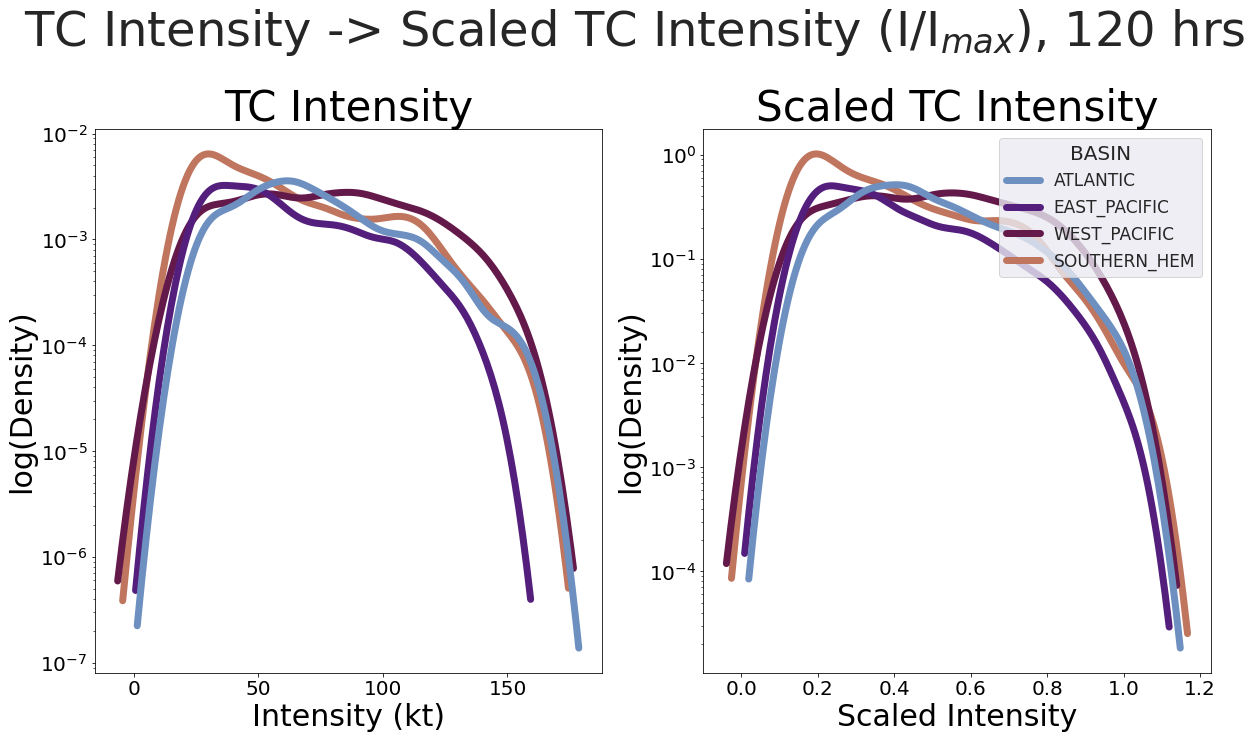

In [21]:
fig1,(ax1a,ax1b) = plt.subplots(1,2,figsize=(20,10))
xsel = SHIPS_process_all#.reset_index()[SHIPS_process_all.reset_index()['BASIN'].isin(['ATLANTIC',
                                      #  'SOUTHERN_HEM'])].set_index(['BASIN','ATCF ID','CASE','TIME'])
time_sel = 120

sns.set_style("darkgrid")
xsel['VMAX log'] = np.log(xsel['VMAX'].astype('float64'))
xsel['IS log'] = np.log(xsel['I_scaled'].astype('float64'))
sns.kdeplot(data=xsel.xs(time_sel,level=3).reset_index(),x='VMAX',hue='BASIN',linewidth=7,
           palette='twilight',ax=ax1a,legend=False)
ax1a.set_xlabel('Intensity (kt)',fontsize=30)
ax1a.set_ylabel('log(Density)',fontsize=30)
ax1a.tick_params(axis='both',labelsize=20)
ax1a.set_yscale('log')

#sns.move_legend(ax1a, "upper right", fontsize=17,title_fontsize=20)
ax1a.set_title('TC Intensity',fontsize=42)
#
sns.kdeplot(data=xsel.xs(time_sel,level=3).reset_index(),x='I_scaled',hue='BASIN',ax=ax1b,linewidth=7,
           palette='twilight')
ax1b.set_xlabel('Scaled Intensity',fontsize=30)
ax1b.set_ylabel('log(Density)',fontsize=30)
ax1b.tick_params(axis='both',labelsize=20)
sns.move_legend(ax1b, "upper right", fontsize=17,title_fontsize=20)
ax1b.set_title('Scaled TC Intensity',fontsize=42)
ax1b.set_yscale('log')
fig1.suptitle('TC Intensity -> Scaled TC Intensity (I/I$_{{max}}$), {hr} hrs'.format(hr=time_sel),fontsize=48,y=1.05)

<AxesSubplot:xlabel='I_scaled', ylabel='Count'>

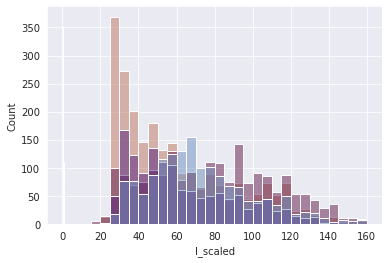

In [22]:
sns.histplot(data=xsel.xs(time_sel,level=3).reset_index(),x='I_scaled',hue='BASIN',linewidth=1,
           palette='twilight',legend=False)
sns.histplot(data=xsel.xs(time_sel,level=3).reset_index(),x='VMAX',hue='BASIN',linewidth=1,
           palette='twilight',legend=False)


In [23]:
from scipy.stats import wasserstein_distance, kstest, ks_2samp
from scipy.linalg import norm

In [24]:
def hellinger2(p, q):
    dx = [1]/np.max(len(p),len(q))
    

In [25]:
def hellinger1(p, q):
    pnorm = (p - np.min(p))/np.max(p)
    qnorm = (q - np.min(q))/np.max(q)
    # pnorm = p.astype(float)
    # qnorm = q.astype(float)
    return np.sqrt(0.5 * ((np.sqrt(pnorm) - np.sqrt(qnorm))**2).sum())

In [26]:
pdf_dist_ALL = pd.DataFrame()
basin_all = xsel.reset_index()['BASIN'].unique()
fore_time_all = xsel.reset_index()['TIME'].unique()
for bas_1 in basin_all:
    for bas_2 in basin_all:
        pdf_dist = pd.DataFrame(columns={'Basin 1','Basin 2','Forecast time','Wasserstein VMAX',
                    'Wasserstein IS','KS VMAX','KS IS','Hell VMAX','Hell IS'},index=fore_time_all)
        pdf_dist['Basin 1'] = bas_1
        pdf_dist['Basin 2'] = bas_2
        for ifore in fore_time_all:
            xs = xsel.xs(ifore,level=3)
            wd_v = wasserstein_distance(xs.xs(bas_1).reset_index()['VMAX'],xs.xs(bas_2).reset_index()['VMAX'])
            wd_i = wasserstein_distance(xs.xs(bas_1).reset_index()['I_scaled'],xs.xs(bas_2).reset_index()['I_scaled'])
            #
            ks_v = ks_2samp(xs.xs(bas_1).reset_index()['VMAX log'],xs.xs(bas_2).reset_index()['VMAX log'])
            ks_i = ks_2samp(xs.xs(bas_1).reset_index()['IS log'],xs.xs(bas_2).reset_index()['IS log'])
            #
            he_v = hellinger1(xs.xs(bas_1).reset_index()['VMAX'].astype(float),
                              xs.xs(bas_2).reset_index()['VMAX'].astype(float))
            he_i = hellinger1(xs.xs(bas_1).reset_index()['I_scaled'].astype(float),
                              xs.xs(bas_2).reset_index()['I_scaled'].astype(float))
            #print(xs.xs(bas_1).reset_index()['IS log'])
           # print(xs.xs(bas_2).reset_index()['IS log'])
            #
            pdf_dist['Wasserstein VMAX'].loc[ifore] = wd_v
            pdf_dist['Wasserstein IS'].loc[ifore] = wd_i
            pdf_dist['KS VMAX'].loc[ifore] = ks_v[0]
            pdf_dist['KS IS'].loc[ifore] = ks_i[0]
            pdf_dist['Hell VMAX'].loc[ifore] = he_v
            pdf_dist['Hell IS'].loc[ifore] = he_i
        pdf_dist_ALL = pdf_dist_ALL.append(pdf_dist)
            



In [27]:
outflow_str

'outflow_avg'

In [28]:
pdf_dist_ALL = pdf_dist_ALL.reset_index()
pdf_dist_ALL = pdf_dist_ALL.rename(columns={'index':'TIME'})
pdf_dist_ALL['Basin 1 plt'] = pdf_dist_ALL['Basin 1']
pdf_dist_ALL['Basin 2 plt'] = pdf_dist_ALL['Basin 2']


In [29]:
pdf_dist_ALL['Basin 1 plt'] = pdf_dist_ALL['Basin 1 plt'].replace({'ATLANTIC':0,'EAST_PACIFIC':1,'WEST_PACIFIC':2,
                                                                  'SOUTHERN_HEM':3})

In [30]:
pdf_dist_ALL['Basin 2 plt'] = pdf_dist_ALL['Basin 2 plt'].replace({'ATLANTIC':0,'EAST_PACIFIC':1,'WEST_PACIFIC':2,
                                                                  'SOUTHERN_HEM':3})

In [31]:
pdf_dist_ALL['Wasserstein IS'] = pdf_dist_ALL['Wasserstein IS'].astype(float)
pdf_dist_ALL['Wasserstein VMAX'] = pdf_dist_ALL['Wasserstein VMAX'].astype(float)
pdf_dist_ALL['Wasserstein diff'] = pdf_dist_ALL['Wasserstein IS'] - pdf_dist_ALL['Wasserstein VMAX']
#
pdf_dist_ALL['KS IS'] = pdf_dist_ALL['KS IS'].astype(float)
pdf_dist_ALL['KS VMAX'] = pdf_dist_ALL['KS VMAX'].astype(float)
pdf_dist_ALL['KS diff'] = pdf_dist_ALL['KS IS'] - pdf_dist_ALL['KS VMAX']
#
pdf_dist_ALL['Hell IS'] = pdf_dist_ALL['Hell IS'].astype(float)
pdf_dist_ALL['Hell VMAX'] = pdf_dist_ALL['Hell VMAX'].astype(float)
pdf_dist_ALL['Hell diff'] = pdf_dist_ALL['Hell IS'] - pdf_dist_ALL['Hell VMAX']

In [32]:
hm_KS = pd.pivot_table(data=pdf_dist_ALL,
                     values=['KS diff'],
                     index = ['Basin 1','TIME'], columns = 'Basin 2')
#
hm_WS = pd.pivot_table(data=pdf_dist_ALL,
                     values=['Wasserstein diff'],
                     index = ['Basin 1','TIME'], columns = 'Basin 2')
#
hm_HE = pd.pivot_table(data=pdf_dist_ALL,
                     values=['Hell diff'],
                     index = ['Basin 1','TIME'], columns = 'Basin 2')


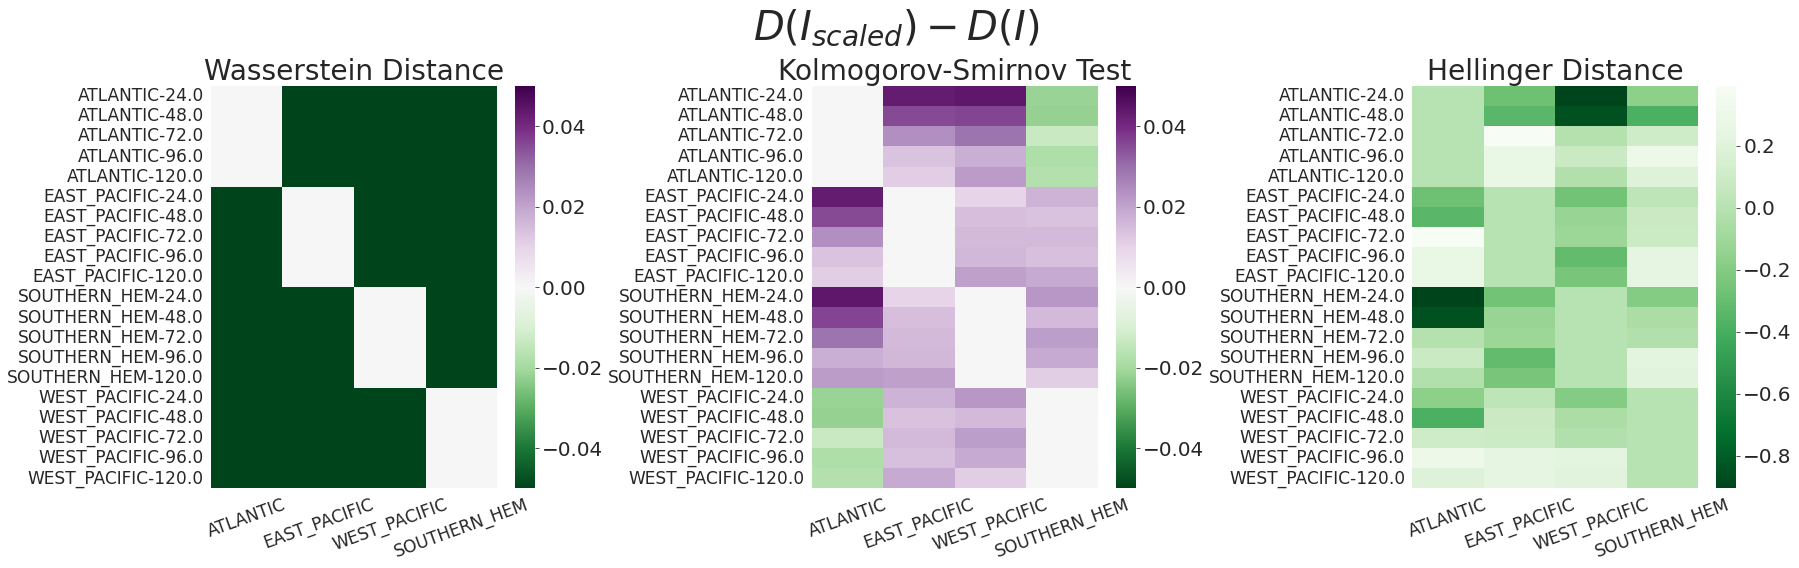

In [33]:
fig1,(ax1a,ax1b,ax1c) = plt.subplots(1,3,figsize=(25,8))
pltxa = sns.heatmap(hm_WS,cmap='PRGn_r',vmin=-0.05,vmax=0.05,ax=ax1a)
ax1a.set_xticklabels(pdf_dist_ALL['Basin 2'].unique(),rotation=20,fontsize=20)
ax1a.tick_params('both',labelsize=17)
ax1a.set_xlabel(None)
ax1a.set_ylabel(None)
cbara = pltxa.collections[0].colorbar
cbara.ax.tick_params(labelsize=20)
ax1a.set_title('Wasserstein Distance',fontsize=28)
#
pltxb = sns.heatmap(hm_KS,cmap='PRGn_r',vmin=-0.05,vmax=0.05,ax=ax1b)
ax1b.set_xticklabels(pdf_dist_ALL['Basin 2'].unique(),rotation=20,fontsize=20)
ax1b.tick_params('both',labelsize=17)
ax1b.set_xlabel(None)
ax1b.set_ylabel(None)
cbarb = pltxb.collections[0].colorbar
cbarb.ax.tick_params(labelsize=20)
ax1b.set_title('Kolmogorov-Smirnov Test',fontsize=28)
#
pltxc = sns.heatmap(hm_HE,cmap='Greens_r',ax=ax1c)#,vmin=-8,vmax=0)
ax1c.set_xticklabels(pdf_dist_ALL['Basin 2'].unique(),rotation=20,fontsize=20)
ax1c.tick_params('both',labelsize=17)
ax1c.set_xlabel(None)
ax1c.set_ylabel(None)
cbarc = pltxc.collections[0].colorbar
cbarc.ax.tick_params(labelsize=20)
ax1c.set_title('Hellinger Distance',fontsize=28)
#
fig1.suptitle('$D(I_{scaled}) - D(I)$',fontsize=40)
fig1.tight_layout()
#
f1save = 'distance_Iscaled_vs_I_ALL_forecasts.png'
fig1.savefig(f1save,format='png',dpi=300,bbox_inches='tight')

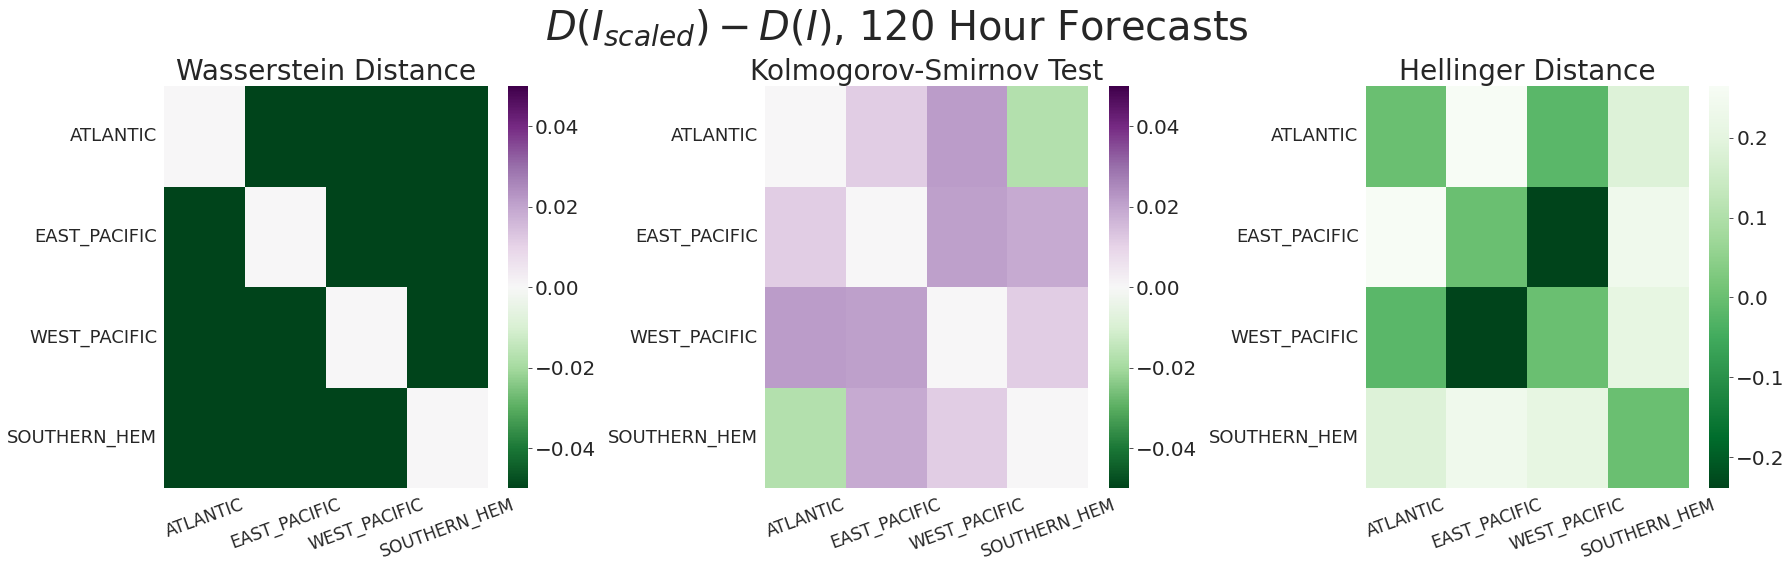

In [34]:
fig2,(ax2a,ax2b,ax2c) = plt.subplots(1,3,figsize=(25,8))
hrs = 120
pltxa = sns.heatmap(hm_WS.xs(hrs,level=1),cmap='PRGn_r',vmin=-0.05,vmax=0.05,ax=ax2a)
ax2a.set_xticklabels(pdf_dist_ALL['Basin 2'].unique(),rotation=20,fontsize=18)
ax2a.tick_params('both',labelsize=17)
ax2a.set_yticklabels(pdf_dist_ALL['Basin 1'].unique(),rotation=0,fontsize=18)
ax2a.set_xlabel(None)
ax2a.set_ylabel(None)
cbara = pltxa.collections[0].colorbar
cbara.ax.tick_params(labelsize=20)
ax2a.set_title('Wasserstein Distance',fontsize=28)
#
pltxb = sns.heatmap(hm_KS.xs(hrs,level=1),cmap='PRGn_r',vmin=-0.05,vmax=0.05,ax=ax2b)
ax2b.set_xticklabels(pdf_dist_ALL['Basin 2'].unique(),rotation=20,fontsize=18)
ax2b.tick_params('both',labelsize=17)
ax2b.set_yticklabels(pdf_dist_ALL['Basin 1'].unique(),rotation=0,fontsize=18)
ax2b.set_xlabel(None)
ax2b.set_ylabel(None)
cbarb = pltxb.collections[0].colorbar
cbarb.ax.tick_params(labelsize=20)
ax2b.set_title('Kolmogorov-Smirnov Test',fontsize=28)
#
pltxc = sns.heatmap(hm_HE.xs(hrs,level=1),cmap='Greens_r',ax=ax2c)#,vmin=-8,vmax=0)
ax2c.set_xticklabels(pdf_dist_ALL['Basin 2'].unique(),rotation=20,fontsize=18)
ax2c.tick_params('both',labelsize=17)
ax2c.set_yticklabels(pdf_dist_ALL['Basin 1'].unique(),rotation=0,fontsize=18)
ax2c.set_xlabel(None)
ax2c.set_ylabel(None)
cbarc = pltxc.collections[0].colorbar
cbarc.ax.tick_params(labelsize=20)
ax2c.set_title('Hellinger Distance',fontsize=28)
#
fig2.suptitle('$D(I_{{scaled}}) - D(I)$, {hrs} Hour Forecasts'.format(hrs=hrs),fontsize=40)
fig2.tight_layout()
f2_save = 'distance_Iscaled_vs_I_{hr}_hr_forecasts_only.png'.format(hr=hrs)
fig2.savefig(f2_save,format='png',dpi=300,bbox_inches='tight')

In [ ]:
pdf_dist_ALL[['Hell IS','Hell VMAX','Hell diff']].head(20)

In [ ]:
xs['IS log'].plot()